In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import random
import math

# Optimizing Makemore with a Simple Neural Net

Goal is to get a decreased loss 

## Creating Dataset

In [7]:
!curl https://raw.githubusercontent.com/karpathy/makemore/master/names.txt > names.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   409k      0 --:--:-- --:--:-- --:--:--  415k


In [9]:
words = [i.strip() for i in open("names.txt").readlines()]
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [11]:
block_size = 3
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


## Base Model

In [12]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [15]:
lri = []
lossi = []
log_lossi = []
epochs = 100000
introduce_decay = 0.8

for idx in range(epochs):
    ix = torch.randint(0,Xtr.shape[0],(32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Ytr[ix])
    loss.backward()

    lr = 0.1 if idx < math.floor(introduce_decay*epochs) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    
    lri.append(lr)
    lossi.append(loss.item())
    log_lossi.append(loss.log10().item())
    

In [16]:
# Training Data set

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1442, grad_fn=<NllLossBackward0>)

In [17]:
# Validation Data set

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1804, grad_fn=<NllLossBackward0>)

## Increasing Embedding Size

In [26]:
BLOCK_SIZE = 3
EMBEDDING_SIZE = 15
INITIAL_INPUT_SIZE = BLOCK_SIZE * EMBEDDING_SIZE

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, EMBEDDING_SIZE), generator=g)
W1 = torch.randn((INITIAL_INPUT_SIZE, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [27]:
lri = []
lossi = []
log_lossi = []
epochs = 200000
introduce_decay = 0.7

for idx in range(epochs):
    ix = torch.randint(0,Xtr.shape[0],(32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,INITIAL_INPUT_SIZE)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Ytr[ix])
    loss.backward()

    lr = 0.1 if idx < math.floor(introduce_decay*epochs) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    
    lri.append(lr)
    lossi.append(loss.item())
    log_lossi.append(loss.log10().item())
    

In [28]:
# Training Data set

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, INITIAL_INPUT_SIZE) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0588, grad_fn=<NllLossBackward0>)

In [29]:
# Validation Data set

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, INITIAL_INPUT_SIZE) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1529, grad_fn=<NllLossBackward0>)

## Increasing Hiden Layer Size

Now we try to add a hidden layer within the model itself

In [41]:
BLOCK_SIZE = 3
EMBEDDING_SIZE = 10
INITIAL_INPUT_SIZE = BLOCK_SIZE * EMBEDDING_SIZE

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, EMBEDDING_SIZE), generator=g)
W1 = torch.randn((INITIAL_INPUT_SIZE, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 100), generator=g)
b2 = torch.randn(100, generator=g)
W3 = torch.randn((100, 27), generator=g)
b3 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2,W3,b3]

for p in parameters:
  p.requires_grad = True

In [42]:
lri = []
lossi = []
log_lossi = []
epochs = 400000
introduce_decay = 0.7

for idx in range(epochs):
    ix = torch.randint(0,Xtr.shape[0],(32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,INITIAL_INPUT_SIZE)@W1+b1)
    l1 = h @ W2 + b2
    logits = l1 @ W3 + b3

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Ytr[ix])
    loss.backward()

    lr = 0.1 if idx < math.floor(introduce_decay*epochs) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    
    lri.append(lr)
    lossi.append(loss.item())
    log_lossi.append(loss.log10().item())
    

In [43]:
# Training Data set

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, INITIAL_INPUT_SIZE) @ W1 + b1) # (32, 100)
l1 = h @ W2 + b2
logits = l1 @ W3 + b3
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1928, grad_fn=<NllLossBackward0>)

In [44]:
# Validation Data set

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, INITIAL_INPUT_SIZE) @ W1 + b1) # (32, 100)
l1 = h @ W2 + b2
logits = l1 @ W3 + b3
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2243, grad_fn=<NllLossBackward0>)

## Increasing Context Size

In [78]:
block_size = 4
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182512, 4]) torch.Size([182512])
torch.Size([22860, 4]) torch.Size([22860])
torch.Size([22774, 4]) torch.Size([22774])


In [79]:
EMBEDDING_SIZE = 10
INITIAL_INPUT_SIZE = block_size * EMBEDDING_SIZE

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, EMBEDDING_SIZE), generator=g)
W1 = torch.randn((INITIAL_INPUT_SIZE, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 100), generator=g)
b2 = torch.randn(100, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [90]:
lri = []
lossi = []
log_lossi = []
epochs = 200000
introduce_decay = 0.8

for idx in range(epochs):
    ix = torch.randint(0,Xtr.shape[0],(32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,INITIAL_INPUT_SIZE)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Ytr[ix])
    loss.backward()

    lr = 0.1 if idx < math.floor(introduce_decay*epochs) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    
    lri.append(lr)
    lossi.append(loss.item())
    log_lossi.append(loss.log10().item())
    

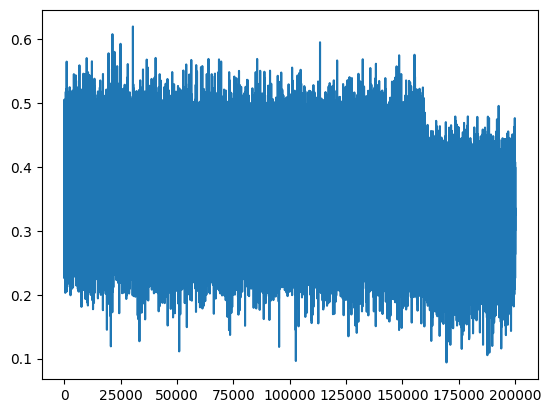

In [91]:
plt.plot([i for i in range(epochs)], log_lossi)

In [92]:
# Training Data set
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, INITIAL_INPUT_SIZE) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0934, grad_fn=<NllLossBackward0>)

In [93]:
# Training Data set
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, INITIAL_INPUT_SIZE) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1366, grad_fn=<NllLossBackward0>)

## Adding a random lr change and increasing block size


In [94]:
block_size = 4
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182484, 4]) torch.Size([182484])
torch.Size([22869, 4]) torch.Size([22869])
torch.Size([22793, 4]) torch.Size([22793])


In [108]:
EMBEDDING_SIZE = 10
INITIAL_INPUT_SIZE = block_size * EMBEDDING_SIZE

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, EMBEDDING_SIZE), generator=g)
W1 = torch.randn((INITIAL_INPUT_SIZE, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 100), generator=g)
b2 = torch.randn(100, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [109]:
lri = []
lossi = []
log_lossi = []
epochs = 200000
introduce_decay = 0.8

for idx in range(epochs):
    ix = torch.randint(0,Xtr.shape[0],(32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,INITIAL_INPUT_SIZE)@W1+b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None
    
    loss = F.cross_entropy(logits,Ytr[ix])
    loss.backward()

    if random.uniform(0, 1) < 0.95:
        lr = 0.1 if idx < math.floor(introduce_decay*epochs) else 0.01
    else:
        lr = random.uniform(0, 1)
    
    for p in parameters:
        p.data += -lr * p.grad

    
    lri.append(lr)
    lossi.append(loss.item())
    log_lossi.append(loss.log10().item())
    

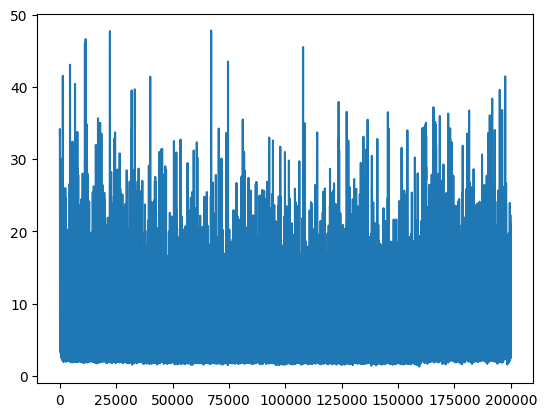

In [110]:
plt.plot([i for i in range(epochs)], lossi)

In [111]:
# Training Data set
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, INITIAL_INPUT_SIZE) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(6.6411, grad_fn=<NllLossBackward0>)

In [112]:
# Training Data set
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, INITIAL_INPUT_SIZE) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(6.6683, grad_fn=<NllLossBackward0>)